# Notebook to test QL 

In [1]:
import datetime as dt
import os
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_directory = os.path.abspath(os.path.join(".","..", "data"))
anchor_date = dt.date(2022, 2, 28)

# Data is Saudi Government Sukuks
data_directory =os.path.join(data_directory,f"ql_{anchor_date:%Y-%m-%d}_yield_curve_points.csv")
yield_curve_input = pd.read_csv(data_directory, sep=",")
yield_curve_input["Maturity Date"] = pd.to_datetime(yield_curve_input["Maturity Date"])

In [3]:
# Extracting deposits data
deposit_maturities = list(yield_curve_input.loc[yield_curve_input["Type"] == "Deposit"]["Maturity Date"])
deposit_maturities.insert(0, pd.to_datetime(anchor_date))
deposit_rates = list(yield_curve_input.loc[yield_curve_input["Type"] == "Deposit"]["Adjusted YTM"])
deposit_rates.insert(0, deposit_rates[0])

# Extracting bonds data
bond_maturities = list(yield_curve_input.loc[yield_curve_input["Type"] == "Bond"]["Maturity Date"])
bond_rates = list(yield_curve_input.loc[yield_curve_input["Type"] == "Bond"]["Adjusted YTM"])

In [4]:
# Parameters
ql_calc_date = ql.Date(anchor_date.day, anchor_date.month, anchor_date.year)
ql.Settings.instance().evaluationDate = ql_calc_date
calendar = ql.SaudiArabia()
business_convention = ql.Following
day_count = ql.Actual360()
end_of_month = False
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)

In [5]:
# Constructing helpers
depo_helpers = []
for r, m in zip(deposit_rates, deposit_maturities): 
    maturity = ql.Period(ql.Actual360().dayCount(ql_calc_date, ql.Date(m.day, m.month, m.year)), ql.Days)
    depo_helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r)),
                                             maturity,
                                             settlement_days,
                                             calendar,
                                             business_convention,
                                             end_of_month,
                                             day_count))

bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    maturity = ql_calc_date + ql.Period(ql.Actual360().dayCount(ql_calc_date, ql.Date(m.day, m.month, m.year)), ql.Days)
    schedule = ql.Schedule(ql_calc_date,
                           maturity,
                           coupon_frequency,
                           calendar,
                           business_convention,
                           business_convention,
                           ql.DateGeneration.Backward,
                           end_of_month)

    bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                         settlement_days,
                                         face_amount,
                                         schedule,
                                         [r],
                                         day_count,
                                         business_convention)
    bond_helpers.append(bond_helper)

# Combining helpers
rate_helpers = depo_helpers + bond_helpers

In [6]:
def get_spot_rates(yieldcurve, day_count, calendar=ql.SaudiArabia(), months=361):
    
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Annual
        extrapolate = True
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq, extrapolate)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count,compounding,freq,calc_date,d).rate()
        spots.append(eq_rate)
    
    return pd.DataFrame(zip(tenors, spots), columns=["Maturities","Curve"], index=['']*len(tenors))

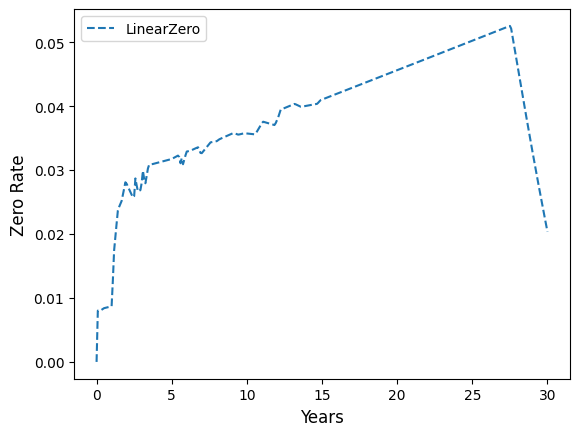

In [7]:
# Interpolation
yc_linearzero = ql.PiecewiseLinearZero(ql_calc_date, rate_helpers, day_count)
splz = get_spot_rates(yc_linearzero, day_count)

# Plotting
plt.plot(splz["Maturities"],splz["Curve"],'--', label="LinearZero")
plt.xlabel("Years", size=12)
plt.ylabel("Zero Rate", size=12)
plt.legend(loc=0)